# Задание Ultra pro

1.  Выберите другую симуляцию из окружений openAI (можно из той же серии для движка box2d https://gym.openai.com/envs/#box2d).

2. С помощью генетического алгоритма обучите объект выбранной симуляции выполнять поставленную задачу.

# Симуляция **CartPole-v1**
https://gym.openai.com/envs/CartPole-v1/

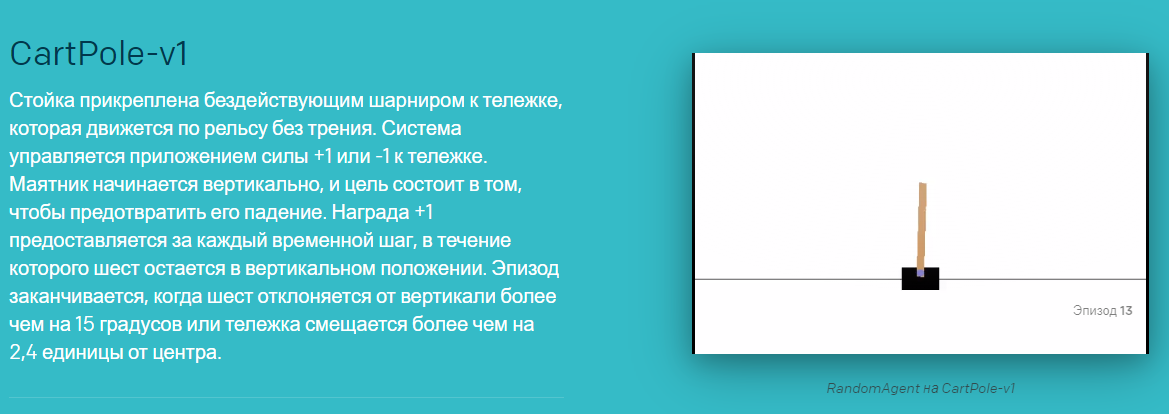

# Начальная настройка

## Настройка окружения Colab



In [ ]:
!apt install swig cmake libopenmpi-dev zlib1g-dev 
!pip install stable-baselines==2.5.1 box2d box2d-kengz 
!pip install gym pyvirtualdisplay > /dev/null 2>&1 
!pip install xvfbwrapper 
!apt-get update 
!sudo apt-get install xvfb 
!apt-get install xdpyinfo

## Импорт библиотек



In [ ]:
import gym 
from gym import logger as gymlogger
from gym.wrappers import Monitor 
gymlogger.set_level(40) 
import numpy as np 
import random 
import matplotlib 
import matplotlib.pyplot as plt 
%matplotlib inline
import glob 
import io 
import base64 
from IPython.display import HTML 
import time

from IPython import display as ipythondisplay 
from pyvirtualdisplay import Display

In [ ]:
# Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе
display = Display(visible=0, size=(1400, 900))
display.start()

## Основные функции отображения видео

In [ ]:
# Функция, позволяющая записывать видео того, что происходит в окружении и отображать это в колабе.
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Запуск среды

In [ ]:
env = gym.make('CartPole-v1')

## Тест среды окружения

### Создание популяции

In [ ]:
numBots = 100
popul = []

In [ ]:
for i in range(numBots):
  bot = np.random.random((4,2))
  popul.append(bot)

In [ ]:
# Пример
popul[0]

array([[0.04491126, 0.02011482],
       [0.18132723, 0.60364165],
       [0.56135658, 0.28268094],
       [0.01058012, 0.15496129]])

### Черновик

In [ ]:
env = wrap_env(env)         #  Декоратор
env.seed(10)                 #  Cимуляция одного окружения
observation = env.reset()
i = 0
action = 0

observation

array([ 0.0092834 ,  0.02169246, -0.04882263,  0.02807027])

In [ ]:
print(env.step(action))

(array([ 0.00626332, -0.36709873, -0.04216206,  0.58203864]), 1.0, False, {})


In [ ]:
env.render()

True

In [ ]:
observation, reward, done,_ = env.step(action)

In [ ]:
print(observation)
print(reward)
print(done)
print(_)
print(action)

[ 0.00971725 -0.17269657 -0.04826122  0.30495822]
1.0
False
{}
0


In [ ]:
popul[np.random.randint(0, numBots-1)]

array([[0.41753659, 0.29237037],
       [0.76686491, 0.08874407],
       [0.77065903, 0.22286926],
       [0.88352844, 0.51141053]])

In [ ]:
observation.shape

(4,)

In [ ]:
# 4x2 - (4,)

result = np.dot(observation, popul[np.random.randint(0, numBots-1)])

print(result.shape)
print(result)

(2,)
[0.22451931 0.07536192]


In [ ]:
action = np.argmax(result)
print(action)

0


### Тест

In [ ]:
env = wrap_env(env)         #  Декоратор
env.seed(10)                 #  Cимуляция одного окружения
observation = env.reset()
i = 0
action = 0

while True:
  env.render()
  observation, reward, done,_ = env.step(action)
  result = np.dot(observation, popul[np.random.randint(0, numBots-1)])
  action = np.argmax(result)
  if done:
    break
env.close()
show_video()

# Функции для ГА

In [ ]:
# Функция получения выжившей популяции

def getSurvPopul(popul, val, nsurv, reverse=True):
    newpopul = []
    sval= sorted(val, reverse=reverse)
    for i in range(nsurv):
        index = val.index(sval[i])
        newpopul.append(popul[index]) 
    return newpopul, sval

In [ ]:
# Функция получения родителей
def getParents(curr_popul, nsurv):   
    indexp1 = random.randint(0, nsurv - 1) 
    indexp2 = random.randint(0, nsurv - 1) 
    botp1 = curr_popul[indexp1]
    botp2 = curr_popul[indexp2]
   
    return botp1,botp2

In [ ]:
# Функция скрещивания
def crossPointFrom2Parents(botp1, botp2, j):
    pindex = np.random.random()
    if pindex < 0.5:
        x = botp1[j]
    else:
        x = botp2[j]
    return x

# 1. Эволюция ботов на **одной** среде

In [ ]:
# Функция расчета вознаграждения за эпизод
def countValue(popul):
  action = 0
  reward_list = []  # Список сумм вознаграждений для каждого эпизода

  for bot in popul:
    env.seed(10)    # Конкретная среда
    env.reset()
    #i = 0
    tmp = 0
    done = False
    while done != True:
      observation, reward, done,_ = env.step(action)
      result = np.dot(observation,bot)
      #print("Bot: ", bot, "result:", result)
      action = np.argmax(result)
      tmp += reward
    reward_list.append(tmp)

  return reward_list

In [ ]:
# Начальные значения

n = 50         # Популяция
nsurv = 10     # Количество выживших
nnew = n-nsurv # Количество новых
epohs = 50     # Количество эпох
mut = 0.1      # Коэфициент мутаций
total=[]       # Список для построения графика

In [ ]:
popul = []     # Популяция

for i in range(n):  
  bot = np.random.random((4,2))
  popul.append(bot)

In [ ]:
#env.close()

0 0.061   [311.0, 289.0, 200.0]
1 0.116   [395.0, 395.0, 375.0]
2 0.278   [500.0, 500.0, 500.0]
3 0.64   [500.0, 500.0, 500.0]
4 0.46   [500.0, 500.0, 500.0]
5 0.609   [500.0, 500.0, 500.0]
6 0.461   [500.0, 500.0, 500.0]
7 0.435   [500.0, 500.0, 500.0]
8 0.441   [500.0, 500.0, 500.0]
9 0.708   [500.0, 500.0, 500.0]
10 0.921   [500.0, 500.0, 500.0]
11 1.286   [500.0, 500.0, 500.0]
12 0.926   [500.0, 500.0, 500.0]
13 1.036   [500.0, 500.0, 500.0]
14 0.956   [500.0, 500.0, 500.0]
15 1.173   [500.0, 500.0, 500.0]
16 1.343   [500.0, 500.0, 500.0]
17 1.071   [500.0, 500.0, 500.0]
18 1.442   [500.0, 500.0, 500.0]
19 1.363   [500.0, 500.0, 500.0]
20 0.545   [500.0, 500.0, 500.0]
21 0.446   [500.0, 500.0, 500.0]
22 0.484   [500.0, 500.0, 500.0]
23 0.447   [500.0, 500.0, 500.0]
24 0.476   [500.0, 500.0, 500.0]
25 0.432   [500.0, 500.0, 500.0]
26 0.446   [500.0, 500.0, 500.0]
27 0.429   [500.0, 500.0, 500.0]
28 0.453   [500.0, 500.0, 500.0]
29 0.461   [500.0, 500.0, 500.0]
30 0.433   [500.0, 500

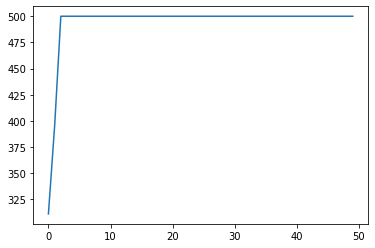

In [ ]:
curr_time = time.time()

for it in range(epohs):
  val = countValue(popul)  # Считаем каждого бота
  newpopul, sval = getSurvPopul(popul, val, nsurv)
  print(it, round((time.time() - curr_time), 3), " ", sval[0:3])


  total.append(sval[0])
  curr_time = time.time()

  for k in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []

    for j in range(len(botp1)):
      x = crossPointFrom2Parents(botp1, botp2, j)
      newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul
  popul = np.array(popul)
plt.plot(total)
print(np.mean(total))

In [ ]:
val = countValue(popul)  # Получаем значения последней популяции
newpopul, sval = getSurvPopul(popul, val, nsurv) 

In [ ]:
env = wrap_env(env)
env.seed(0) 
observation = env.reset()
i=0
action = 0
while True:
    env.render() 
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,newpopul[0])    # Подаем лучшего бота
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

## 1.1. Данная популяция на **случайном** окружении

## Вариант 1

In [ ]:
env = wrap_env(env)

observation = env.reset()
i=0
action = 0
while True:
    env.render() 
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,newpopul[0])    # Подаем лучшего бота
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

## Вариант 2

In [ ]:
env = wrap_env(env)

observation = env.reset()
i=0
action = 0
while True:
    env.render() 
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,newpopul[0])    # Подаем лучшего бота
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

# 2. Эволюция ботов на **случайно** сгенерированных средах

In [ ]:
# Функция расчета вознаграждения за эпизод
def countValue(popul):
  action = 0
  reward_list = []  # Список сумм вознаграждений для каждого эпизода

  for bot in popul:
    env.reset()
    tmp = 0
    done = False
    while done != True:
      observation, reward, done,_ = env.step(action)
      result = np.dot(observation,bot)
      action = np.argmax(result)
      tmp += reward
    reward_list.append(tmp)

  return reward_list

In [ ]:
# Начальные значения

n = 30         # Популяция
nsurv = 5     # Количество выживших
nnew = n-nsurv # Количество новых
epohs = 50     # Количество эпох
mut = 0.1      # Коэфициент мутаций

In [ ]:
popul = []     # Популяция

for i in range(n):  
  bot = np.random.random((4,2))
  popul.append(bot)

In [ ]:
# Удаляем переменные после прошлого эксперимента
del val
del newpopul
del sval
del total

In [ ]:
#env.close()

0 0.042   [500.0, 500.0, 182.0]
1 0.097   [500.0, 500.0, 500.0]
2 0.242   [500.0, 500.0, 500.0]
3 0.249   [500.0, 500.0, 500.0]
4 0.257   [500.0, 500.0, 500.0]
5 0.257   [500.0, 500.0, 500.0]
6 0.236   [500.0, 500.0, 500.0]
7 0.265   [500.0, 500.0, 500.0]
8 0.402   [500.0, 500.0, 500.0]
9 0.816   [500.0, 500.0, 500.0]
10 0.701   [500.0, 500.0, 500.0]
11 0.68   [500.0, 500.0, 500.0]
12 0.644   [500.0, 500.0, 500.0]
13 0.828   [500.0, 500.0, 500.0]
14 0.578   [500.0, 500.0, 500.0]
15 0.778   [500.0, 500.0, 500.0]
16 0.882   [500.0, 500.0, 500.0]
17 0.684   [500.0, 500.0, 500.0]
18 0.235   [500.0, 500.0, 500.0]
19 0.247   [500.0, 500.0, 500.0]
20 0.254   [500.0, 500.0, 500.0]
21 0.272   [500.0, 500.0, 500.0]
22 0.245   [500.0, 500.0, 500.0]
23 0.246   [500.0, 500.0, 500.0]
24 0.265   [500.0, 500.0, 500.0]
25 0.255   [500.0, 500.0, 500.0]
26 0.247   [500.0, 500.0, 500.0]
27 0.237   [500.0, 500.0, 500.0]
28 0.254   [500.0, 500.0, 500.0]
29 0.269   [500.0, 500.0, 500.0]
30 0.239   [500.0, 50

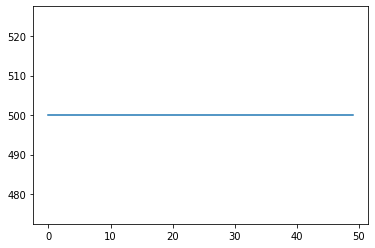

In [ ]:
total=[]       # Список для построения графика
curr_time = time.time()

for it in range(epohs):
  val = countValue(popul)  # Считаем каждого бота
  newpopul, sval = getSurvPopul(popul, val, nsurv)
  print(it, round((time.time() - curr_time), 3), " ", sval[0:3])


  total.append(sval[0])
  curr_time = time.time()

  for k in range(nnew):
    botp1, botp2 = getParents(newpopul, nsurv)
    newbot = []

    for j in range(len(botp1)):
      x = crossPointFrom2Parents(botp1, botp2, j)
      newbot.append(x)
    newpopul.append(newbot)
  popul = newpopul
  popul = np.array(popul)
plt.plot(total)
print(np.mean(total))

## 2.1. Данная популяция на **случайном** окружении

## Вариант 1

In [ ]:
env = wrap_env(env)

observation = env.reset()
i=0
action = 0
while True:
    env.render() 
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,newpopul[0])    # Подаем лучшего бота
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

## Вариант 2

In [ ]:
env = wrap_env(env)

observation = env.reset()
i=0
action = 0
while True:
    env.render() 
    observation,reward,done,_ = env.step(action)
    result = np.dot(observation,newpopul[0])    # Подаем лучшего бота
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

# Выводы:

1. **Генетические алгоритмы** служат для какой-нибудь оптимизации. В данном случаи игрового процесса.
2. Для решения задачи требуется получить матрицу размером (4,2)
3. Для достижения поставленной задачи(удержания шеста на тележке) не требуется большого количества эпох. 
4. Обучение происходит очень быстро.
5. При тесте на любой среде генетический алгоритм **справляется** с задачей. 